# Sync time analysis

Mitchell Krawiec-Thayer (Isthmus)

A few years ago, I spun up Monero nodes on different instances with varying resource constraints, to see how it impacted sync time. This was mostly an experiment inspired by personal curiosity, **however knowing the degree to which CPU/memory constraints impact block processing speed actually has useful implications for understanding empirical scalability and driving data-informed protocol design.**

A more 'controlled' experiment would vary the CPU and RAM separately to isolate their impact, but I was paying for the compute time out of pocket and couldn't afford the server time to execute a search grid or anything like that. (Just wanted to see how much of a difference there was between sync time for a flimsy node and a beefy node).

A full search grid might be something like a 2 x 9 x 9 grid for:
+ Spinning vs solid state drive
+ Low / medium / high CPU
+ Low / medium / high RAM

This could be done by hand, or a slick solution would be to use Terraform and Ansible to automatically launch and configure an instance with each profile. To collect clean experimental data for the logs here, I simply spun up the a fresh instance, installed the Monero node, let it sync uninterrupted, then pulled the logs and terminated the node as soon as it caught up to head. Logs from machines "in the wild" (not single-purpose reseach instances) can provide *upper bound* values on block verification times (rather than exact values), since it is not known what other processes were using resources. (I do not plan to pursue this personally, but having rigorous benchmarks for existing and tentative tech could be useful, so **I welcome others to carry out experiments and use these scripts to analyze them**, or run with this as a research project. I'm happy to help if I can)

## Import libraries

In [1]:
import isthmuslib  # v0.0.56 << the interface is still fluid, pin the version if you're having issues
from typing import Dict, List, Tuple
import pathlib
from copy import deepcopy

/home/bird/Projects/GitHub/sync-analysis/env/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Settings

### Specify log file locations

In [2]:
log_directory: pathlib.Path = pathlib.Path.cwd() / 'data' / 'version_controlled'
log_filenames: List[str] = ['sync_16_GB_6_CPU.txt', 'sync_192_GB_32_CPU.txt']

Here is what the raw log files from a syncing Monero node look like:

```
bitmonero.log-2018-08-30-22-05-06:2018-08-30 22:05:05.981	[P2P8]	INFO 	global	src/cryptonote_protocol/cryptonote_protocol_handler.inl:1171	[1;33m[94.61.229.18:18080 OUT]  Synced 26936/1650571 (0.453544 sec, 220.485774 blocks/sec), 19.487507 MB queued: [27035:oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo.oooo...][0m
bitmonero.log-2018-08-30-22-05-14:2018-08-30 22:05:06.343	[P2P8]	INFO 	global	src/cryptonote_protocol/cryptonote_protocol_handler.inl:1171	[1;33m[94.61.229.18:18080 OUT]  Synced 27036/1650571 (0.361146 sec, 276.896324 blocks/sec), 19.479160 MB queued: [27135:ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo.ooooo...][0m
bitmonero.log-2018-08-30-22-05-14:2018-08-30 22:05:06.756	[P2P8]	INFO 	global	src/cryptonote_protocol/cryptonote_protocol_handler.inl:1171	[1;33m[94.61.229.18:18080 OUT]  Synced 27136/1650571 (0.409780 sec, 244.033384 blocks/sec), 19.729010 MB queued: [27235:oooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo.ooooo.o..][0m
bitmonero.log-2018-08-30-22-05-14:2018-08-30 22:05:07.139	[P2P8]	INFO 	global	src/cryptonote_protocol/cryptonote_protocol_handler.inl:1171	[1;33m[94.61.229.18:18080 OUT]  Synced 27236/1650571 (0.381557 sec, 262.084040 blocks/sec), 19.738058 MB queued: [27335:ooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo.ooooooo...][0m
bitmonero.log-2018-08-30-22-05-14:2018-08-30 22:05:07.550	[P2P8]	INFO 	global	src/cryptonote_protocol/cryptonote_protocol_handler.inl:1171	[1;33m[94.61.229.18:18080 OUT]  Synced 27336/1650571 (0.409511 sec, 244.193685 blocks/sec), 19.800440 MB queued: 
```

### Specify custom log parsing rules (if necessary)

Isthmuslib contains no-parameter autoparsing tools that you can use for very clean one-line extractions if you are able to have the logs generated with the standard tokens: `[@@@]` between records, with `[<<`varname`=`value`>>]`

In this case we are taking **raw logs from software that I didn't write**, so we provide custom parsing tokens:

In [3]:
# Specify what substring indicates that a new record is starting (lines of logs per row can be many-to-one)
record_delimiter: str = 'monero.'

# Specify names and tokens for parsing each record. Dictionary with items 'varname': ('left_token', 'right_token')
tokens_dictionary: Dict[str, Tuple[str, str]] = {
    'date_time_stamp': ('log-', '\t[P'),
    'height': ('Synced ', '/'),
    'time_to_load': ('(', ' sec'),
}

Additionally, we'll define a small feature engineering helper function that takes the log and performs minor tweaks like extracting unique clean runs, parsing the clunky datetime string into a unix timestamp, and calculating the relative timestamps. We can accomplish this pretty easily by interacting directly with the pandas methods available to the dataframe in the `data` attribute.

**(Note, the next cell is a custom parser for this particular log format, not useful in general)**

In [4]:
def inplace_feature_engineering(log: isthmuslib.VectorMultiset) -> None:
    # Only want syncing data
    log.data.dropna(inplace=True)

    # Just look at the first run if multiple syncs per node
    log.data['height'] = log.data['height'].astype(int)
    log.data = log.data.groupby(by='height').first()
    log.data.reset_index(inplace=True, drop=False)
    log.data.sort_values(by='height', ascending=True, inplace=True, ignore_index=True)

    # Convert datetime strings to timestamps and compute the relative timestamps
    custom_parse = lambda b: isthmuslib.machine_time(f"{b[0]}:{b[1]}:{b[2]}".replace('\t', ''))
    log.data['timestamp'] = [custom_parse(x.split(':')[1:]) for x in log.data['date_time_stamp']]
    min_timestamp: float = min(log.data['timestamp'])
    log.data['relative_timestamp'] = [x - min_timestamp for x in log.data['timestamp']]

## Log extraction and visualization (using `isthmuslib` methods)

Here's the main part, where we loop over the log files. The two main steps are:
+ `log = isthmuslib.extract_file_to_vector(...)` to automatically extract the numeric data out of the raw text logs
+ `log.scatter('height', 'relative_timestamp')` allows us to easily make a plot to peek at any two variables from the log data

We collect the extracted data into an object named `log` with built-in plotting methods such as `log.plot(xname, yname)` or `log.hist(fieldname)`. The `data` attribute at its core is a pandas dataframe (note, you can also pass a flag into the extraction function to just get the dataframe back instead of vector objects)

... Extracting and processing data from file #1 of 2
... Extracting and processing data from file #2 of 2


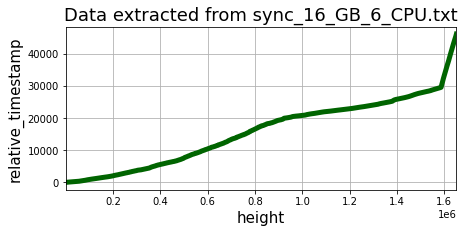

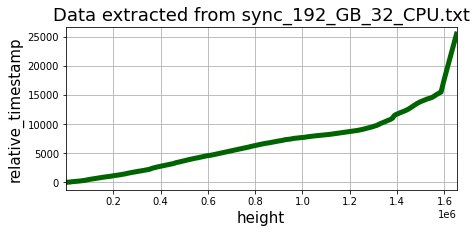

In [5]:
logs: List[isthmuslib.VectorMultiset] = []
disable_progress_bar: bool = True  # Pass None to turn on progress bars
for i, filename in enumerate(log_filenames):
    # Identify the full file path
    full_path: pathlib.Path = log_directory / filename
    print(f"... Extracting and processing data from file #{i + 1} of {len(log_filenames)}")

    # Read in the log
    log: isthmuslib.VectorMultiset = isthmuslib.extract_file_to_vector(full_path,
                                                                       record_delimiter=record_delimiter,
                                                                       tokens_dictionary=tokens_dictionary,
                                                                       disable_progress_bar=disable_progress_bar)

    # Apply feature engineering
    inplace_feature_engineering(log)

    # Plot the run
    log.scatter('height', 'relative_timestamp', title=f"Data extracted from {filename}", figsize=(7, 3))

    # Cache the data
    log.name_root = filename.replace('_', ' ').replace('.txt', '').replace('sync ', '')
    logs.append(deepcopy(log))

## Summary plot (combine data onto same axes with labels and fork heights)

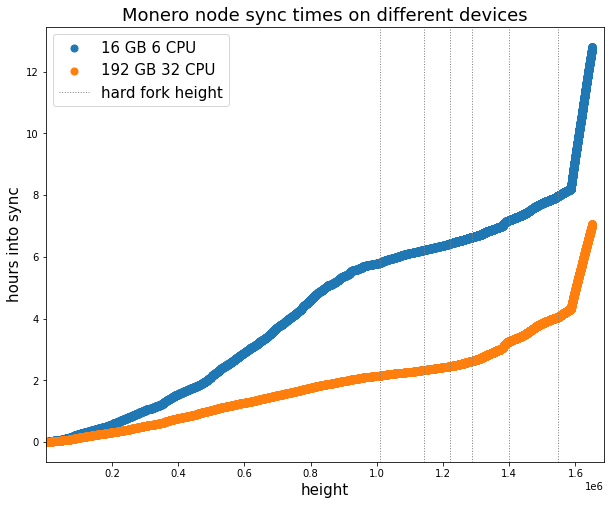

In [6]:
# Make the base scatterplot
isthmuslib.scatter([[log.data.height, log.data.relative_timestamp / (60 * 60)] for log in logs],
                   xlabel='height', ylabel='hours into sync', title='Monero node sync times on different devices',
                   grid=False)

# Add fork heights, since somebody will ask about this
fork_heights: List[int] = [1009827, 1141317, 1220516, 1288616, 1400000, 1546000, 1685555, 1686275]
[isthmuslib.plt.axvline(y, color='gray', linewidth=1, linestyle=':') for y in fork_heights];

# Add a legend (this is accessing `matplotlib.pyplot` as `plt`)
isthmuslib.plt.legend([log.name_root for log in logs] + ['hard fork height'],
                      fontsize=isthmuslib.Style().legend_fontsize);